## CNN for waveform binary classification

The aim is to discriminate between two types of waveforms using a **1D convolutional neural network** :

| | Sine wave | Gaussian sine wave |
|:---|:---:|:---:|
| *Equation* | &nbsp; &nbsp; $y_0 = A_0 sin(2\pi f_0(t-t_0)) + \phi_0$ &nbsp; &nbsp; | &nbsp; &nbsp; $y_1 = A_0 e^{-(t-t_0)^2/2\sigma_0^2} cos(2\pi f_0(t-t_0)) + \phi_0$ &nbsp; &nbsp;|
| *Parameters* | $A_0, f_0, t_0, \phi_0$ | $A_0, f_0, t_0, \phi_0, \sigma_0$ |

### Model

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class Cnn1d(nn.Module):

    def __init__(self):
        super(Cnn1d, self).__init__()
        # [1,1,1000]
        self.conv_1 = nn.Conv1d(in_channels=1, out_channels=6,
                                kernel_size=3, padding=1)
        # [1,6,1000]
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        # [1,6,500]
        self.conv_2 = nn.Conv1d(in_channels=6, out_channels=16,
                                kernel_size=3, padding=1)
        # [1,16,500]
        # After pooling : [1,16,250]
        self.full_connect_1 = nn.Linear(16*250, 500)
        self.full_connect_2 = nn.Linear(500, 100)
        self.full_connect_3 = nn.Linear(100, 2)

    def forward(self, input):
        input = self.maxpool(F.relu(self.conv_1(input)))
        input = self.maxpool(F.relu(self.conv_2(input)))
        input = input.view(1, 16*250)
        input = F.relu(self.full_connect_1(input))
        input = F.relu(self.full_connect_2(input))
        input = F.softmax(self.full_connect_3(input))
        return input

### Input/0utput

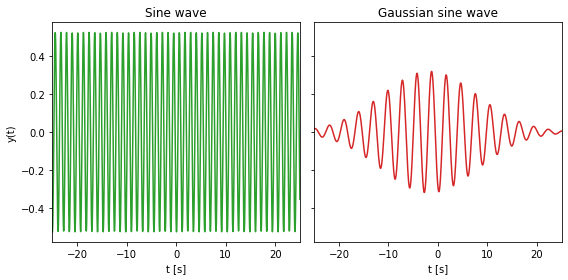

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Waveform generation functions
def sine_wave(t, A0, f0, t0, phi0):
    return A0 * np.sin(2.*np.pi*f0*(t-t0) + phi0)

def gaussian_sine_wave(t, A0, f0, t0, phi0, tau0):
    return A0 * np.exp(-0.5*((t-t0)/tau0)**2) * \
        np.cos(2.*np.pi*f0*(t-t0) + phi0)

# Random wave parameters
N_samples = 200
# Note : only half of this number (half_sample) will be generated
# as waveforms
half_sample = int(N_samples/2)
sample_sz = 1000
A0s = np.random.uniform(0, 2, N_samples)
f0s = np.random.uniform(0, 1, N_samples)
t0s = np.random.uniform(-2, 2, N_samples)
phi0s = np.random.uniform(0, 2*np.pi, N_samples)
tau0s = np.random.uniform(0.1, 10, half_sample)

# Generating waveforms
t = np.linspace(-25, 25, sample_sz)
training_sines = []
training_Gsines = []
for i in range(half_sample):
    training_sines.append(torch.from_numpy(sine_wave(t, A0s[i],
    f0s[i], t0s[i], phi0s[i])))
    training_Gsines.append(torch.from_numpy(gaussian_sine_wave(t,
    A0s[half_sample+i],f0s[half_sample+i],
    t0s[half_sample+i], phi0s[half_sample+i], tau0s[i])))
    # Expanding dimensions to obtain a [N,C_in,L] input
    training_sines[i] = training_sines[i].unsqueeze(0).unsqueeze(0)
    training_Gsines[i] = training_Gsines[i].unsqueeze(0).unsqueeze(0)

# Mixing inputs and associating outputs
labels = np.random.randint(0, 2, half_sample)
training_inputs = []
training_outputs = []
for i in range(half_sample):
    if labels[i] == 0:
        training_inputs.append(training_sines[i])
        training_outputs.append(torch.tensor([[1,0]]))
    else:
        training_inputs.append(training_Gsines[i])
        training_outputs.append(torch.tensor([[0,1]]))

# Display of the 2 classes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4), sharey=True)
ax1.plot(t, training_sines[1][0][0].numpy(), c="tab:green")
ax2.plot(t, training_Gsines[1][0][0].numpy(), c="tab:red")
ax1.set(title="Sine wave", xlabel=r"t [s]", ylabel=r"y(t)",
        xlim=(t[0], t[-1]))
ax2.set(title="Gaussian sine wave", xlabel=r"t [s]",
        xlim=(t[0], t[-1]))
fig.tight_layout()

### Training

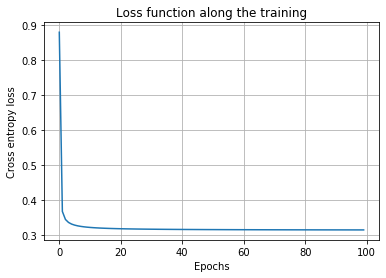

In [13]:
import torch.optim as optim

# CNN instance
model = Cnn1d()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Hyperparameters
learning_rate = 5e-3

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # Relevant for classification
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
# Stochastic Gradient Descent

# Training
epochs = np.arange(100)
errors = np.zeros(len(epochs))
for i in range(half_sample):
    for epoch in epochs:
        # Set the gradients to 0
        optimizer.zero_grad()
        # Forward + backward + optimize
        output = model.forward(training_inputs[i].float())
        loss = loss_fn(output, torch.tensor([labels[i]]))
        loss.backward()
        optimizer.step()
        # Keeping trace of the loss function
        errors[epoch] = loss

# Evolution of the loss function for the last I/O
fig, ax = plt.subplots()
ax.plot(epochs, errors, c="tab:gray")
ax.set(title="Loss function along the training",
xlabel="Epochs", ylabel="Cross entropy loss")
ax.grid()

### Test / performance

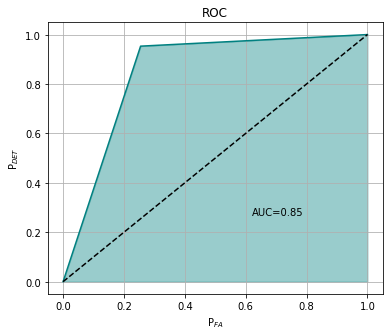

In [28]:
# Sampling
N = 10000
halfN = int(N/2)

# Wave parameters
test_A0s = np.random.uniform(0, 2, N)
test_f0s = np.random.uniform(0, 10, N)
test_t0s = np.random.uniform(-2, 2, N)
test_phi0s = np.random.uniform(0, 2*np.pi, N)
test_tau0s = np.random.uniform(0.1, 10, halfN)

# Generating waveforms
test_sines = []
test_Gsines = []
for i in range(halfN):
    test_sines.append(torch.from_numpy(sine_wave(t, test_A0s[i],
    test_f0s[i], test_t0s[i], test_phi0s[i])))
    test_Gsines.append(torch.from_numpy(gaussian_sine_wave(t,
    test_A0s[halfN+i], test_f0s[halfN+i],
    test_t0s[halfN+i], test_phi0s[halfN+i], test_tau0s[i])))
    # Expanding dimensions to obtain a [N,C_in,L] input
    test_sines[i] = test_sines[i].unsqueeze(0).unsqueeze(0)
    test_Gsines[i] = test_Gsines[i].unsqueeze(0).unsqueeze(0)

# Random mixing of test inputs and associating outputs
test_labels = np.random.randint(0, 2, halfN)
test_inputs = []
for i in range(halfN):
    if test_labels[i] == 0:
        test_inputs.append(test_sines[i])
    else:
        test_inputs.append(test_Gsines[i])

# Feedforward
predicted_labels = np.zeros(halfN)
for i in range(halfN):
    scores = model.forward(test_inputs[i].float())[0]
    if scores[0] > 0.5:
        predicted_labels[i] = 0
    else:
        predicted_labels[i] = 1

# ROC curve / AUC
from sklearn.metrics import roc_curve, roc_auc_score

PFA, PDET, thresh = roc_curve(test_labels, predicted_labels)
AUC = roc_auc_score(test_labels, predicted_labels)

fig, ax = plt.subplots(figsize=(6,5))
ax.plot(PFA, PDET, c="teal")
ax.plot([0,1], [0,1], "--", c="k")
ax.set(xlabel=r"P$_{FA}$", ylabel=r"P$_{DET}$", title="ROC")
ax.fill_between(PFA, PDET, color="teal", alpha=0.4)
ax.text(0.62, 0.27, "AUC={:.2f}".format(AUC))
ax.grid()